<a href="https://colab.research.google.com/github/mkbahk/QuantumComputing/blob/main/MarkovChains_local_aer_NewQiskit_20240409.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [214]:
######################################################
# 코드의 목적: 마르코프체인 행렬을 양자회로를 이용해 계산하는 방법
# 작성자: 박문기(mkbahk@gmail.com)
# 최초작성일: 20230926
# 마지막수정일: 20240308
# 수정사유: Qiskit 1.0.2 Update 반영
######################################################

In [215]:
!python3 -m pip install qiskit[visualization]
!python3 -m pip install qiskit-ionq
!python3 -m pip install qiskit-ibm-provider
!python3 -m pip install qiskit-aer

In [216]:
import qiskit
import qiskit_ionq
import qiskit_ibm_provider
import qiskit_aer

print(qiskit.__version__)
print(qiskit_ionq.__version__)
print(qiskit_ibm_provider.__version__)
print(qiskit_aer.__version__)

1.0.2
0.5.0
0.10.0
0.14.0.1


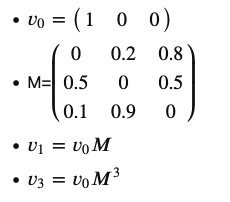

In [217]:
import numpy as np
M = np.array([[0, 0.2, 0.8],
              [0.5, 0, 0.5],
              [0.1, 0.9, 0]])
v0=np.array([1,0,0])

v1=v0.dot(M)
print(v1)
v2=v0.dot(np.linalg.matrix_power(M, 2))
print(v2)
v3=v0.dot(np.linalg.matrix_power(M, 3))
print(v3)

[0.  0.2 0.8]
[0.18 0.72 0.1 ]
[0.37  0.126 0.504]


In [218]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
#from qiskit import *
from numpy import pi

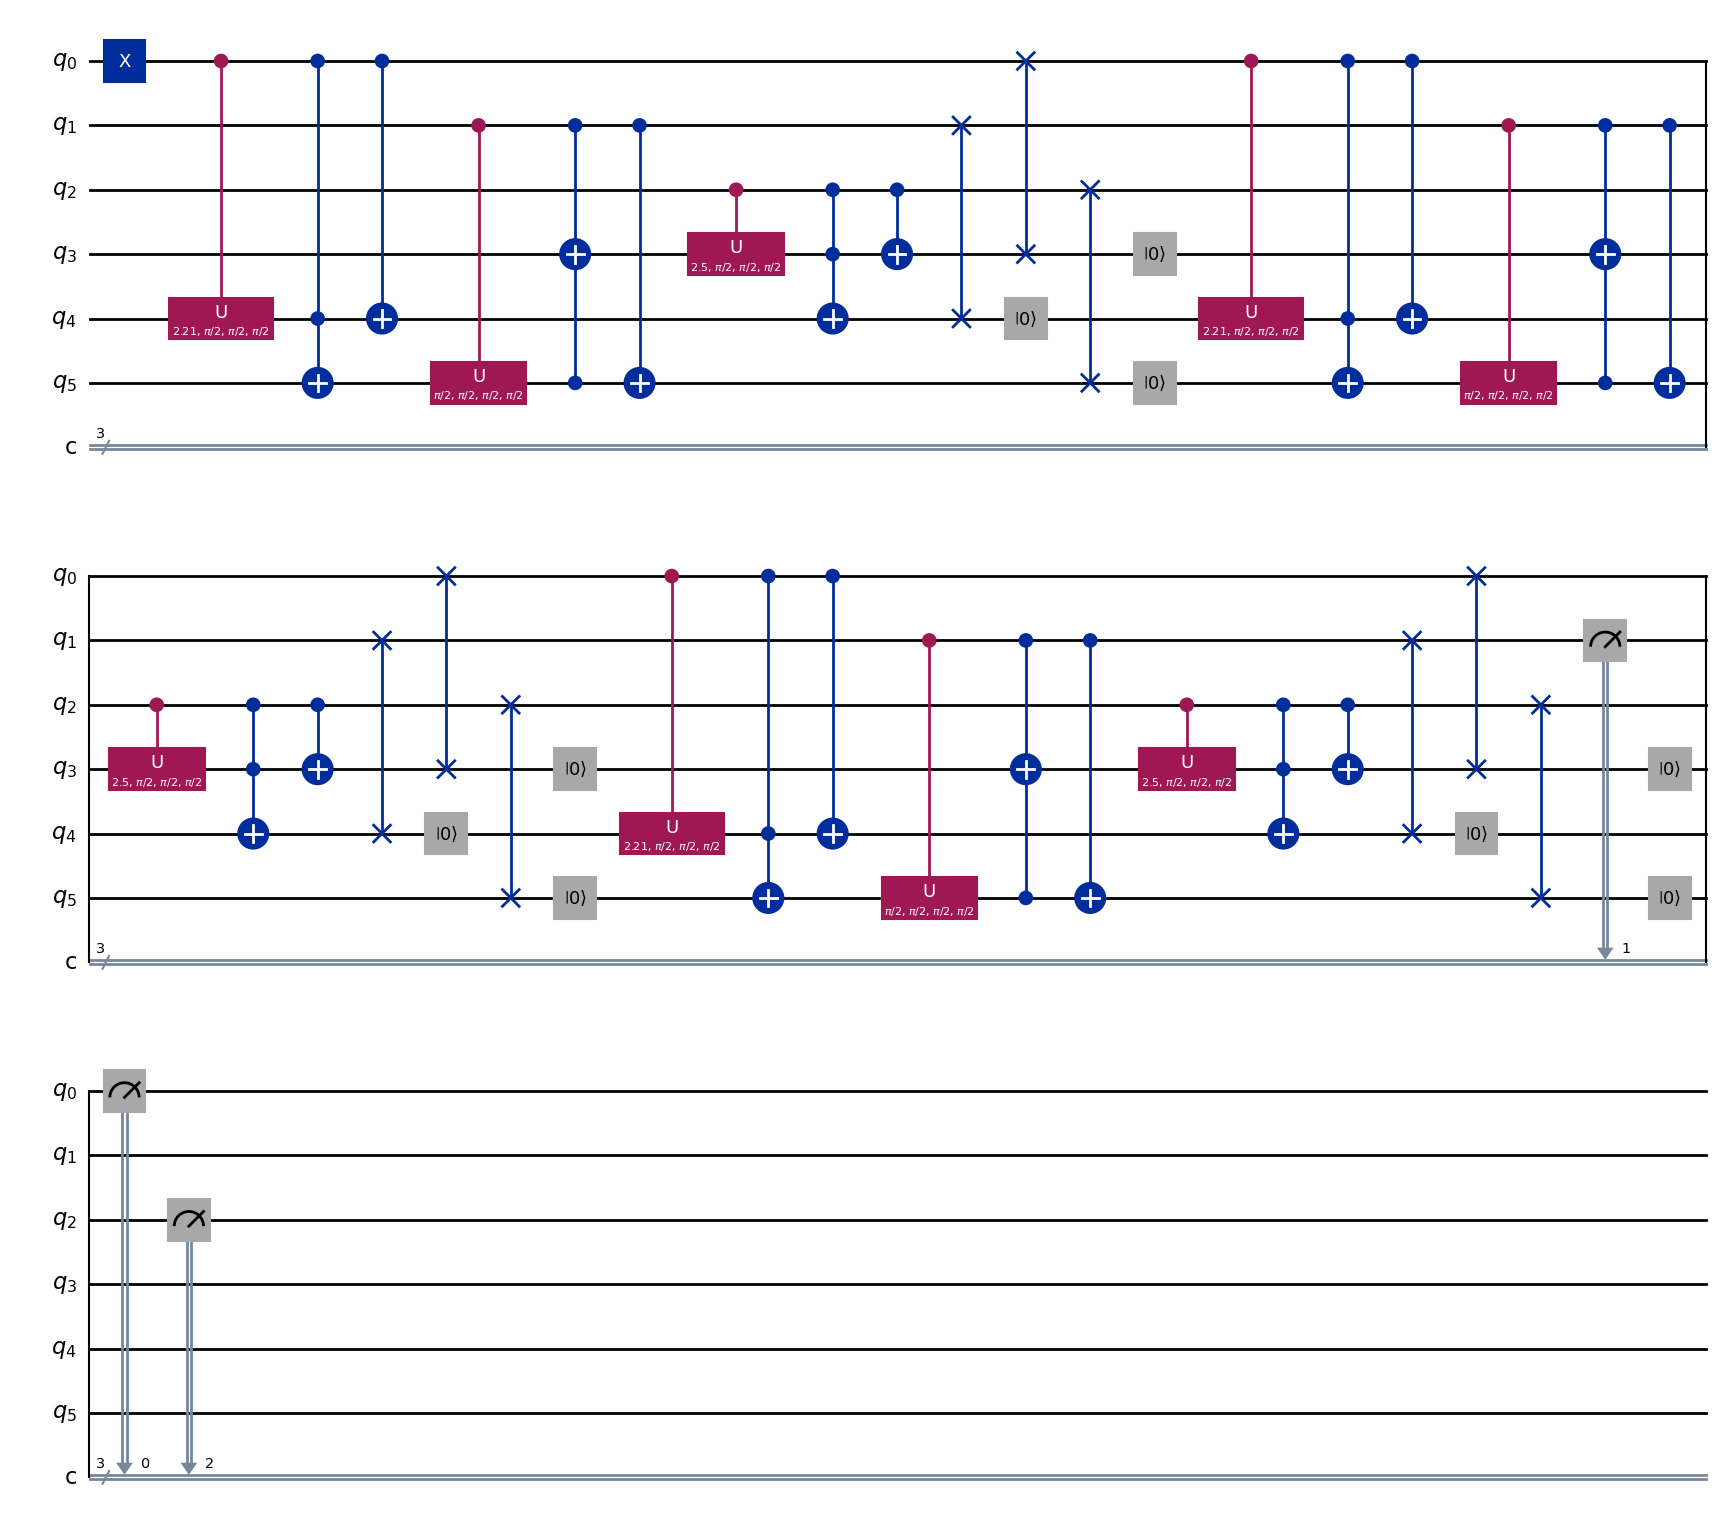

In [219]:
# Inilialise registers
qreg_q = QuantumRegister(6, 'q')
creg_c = ClassicalRegister(3, 'c')

# Create Markov Step as a circuit
markov_qc = QuantumCircuit(qreg_q)

# Create the Markov Step
# From state 0 to state 1 and 2
markov_qc.cu(2*np.arccos(np.sqrt(M[0,1])), pi/2, pi/2, pi/2, qreg_q[0], qreg_q[4])
markov_qc.ccx(qreg_q[4], qreg_q[0], qreg_q[5])
markov_qc.cx(qreg_q[0], qreg_q[4])

# From state 1 to state 0 and 2
markov_qc.cu(2*np.arccos(np.sqrt(M[1,2])), pi/2, pi/2, pi/2, qreg_q[1], qreg_q[5])
markov_qc.ccx(qreg_q[5], qreg_q[1], qreg_q[3])
markov_qc.cx(qreg_q[1], qreg_q[5])

# From state 2 to state 0 and 1
markov_qc.cu(2*np.arccos(np.sqrt(M[2,0])), pi/2, pi/2, pi/2, qreg_q[2], qreg_q[3])
markov_qc.ccx(qreg_q[3], qreg_q[2], qreg_q[4])
markov_qc.cx(qreg_q[2], qreg_q[3])

# Swap
markov_qc.swap(qreg_q[0], qreg_q[3])
markov_qc.swap(qreg_q[1], qreg_q[4])
markov_qc.swap(qreg_q[2], qreg_q[5])

# Initialise circuit
qc = QuantumCircuit(qreg_q, creg_c)

# Initialise state (1,0,0)
qc.x(0)

# Do the markov step n times
n = 3
for _ in range(n):
    for ins in markov_qc:
        qc.append(ins[0], ins[1], ins[2])
    qc.reset(qreg_q[3:])

# Measure outcome
qc.measure(qreg_q[:3], creg_c)
qc.draw('mpl')

In [220]:
# Qiskit Local Simulator 사용하기 위한 준비
from qiskit_aer import Aer

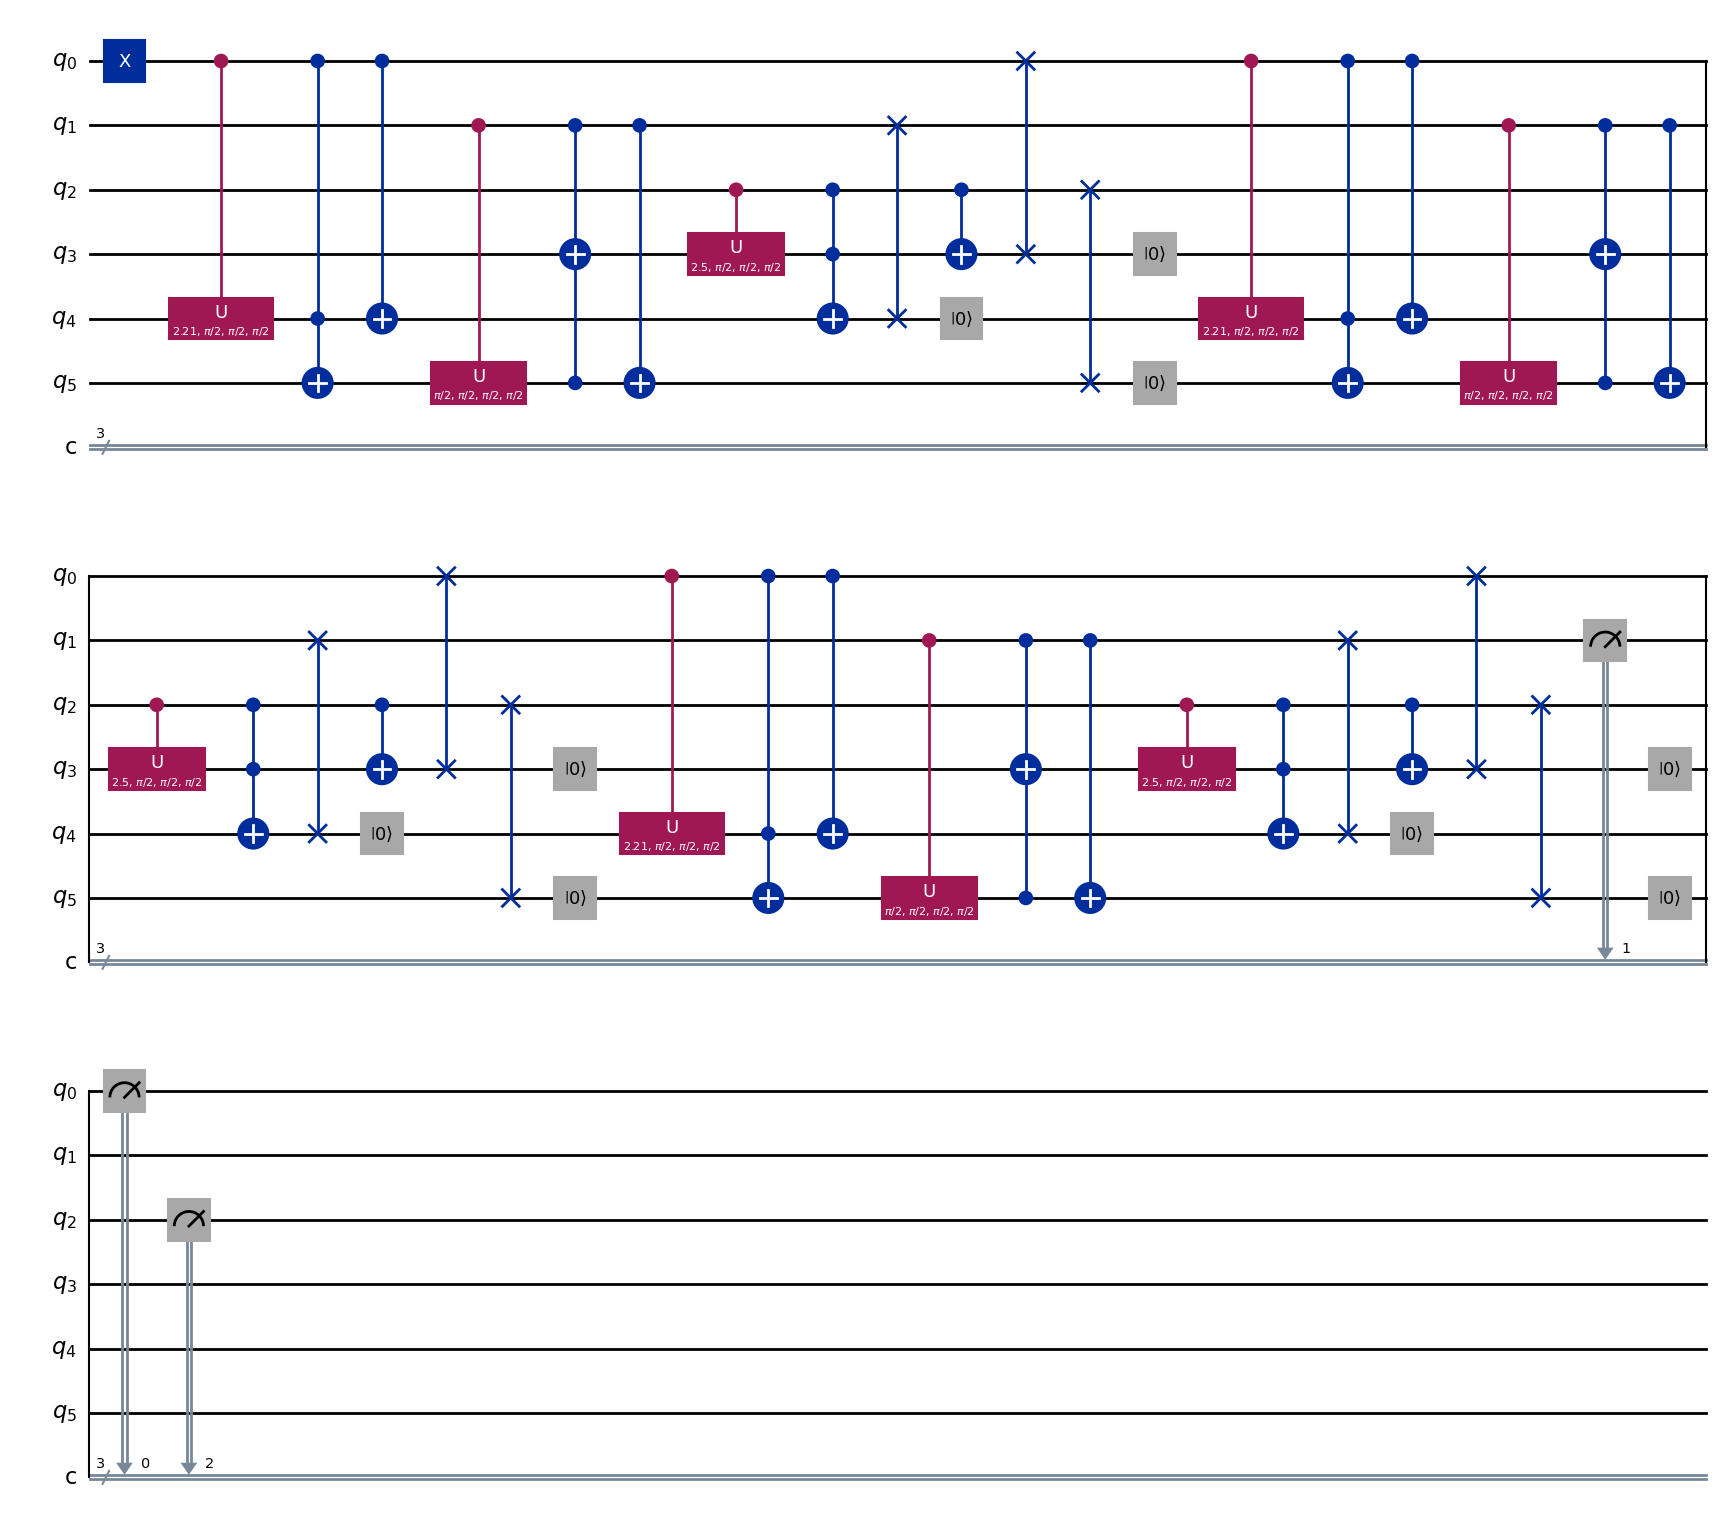

In [221]:
#여러 장치들에게 선택적으로 수행시키기 위한 준비
from qiskit.compiler import transpile, assemble
#
#백엔드들을 이용한 실제 장치나 시뮬레이터를 이용한 실행
#
#backend = ionq_provider.get_backend('ionq_simulator')
#backend = ionq_provider.get_backend('ionq_qpu')
#backend = ionq_provider.get_backend('qpu.aria-1')
#backend = ibm_provider.get_backend('ibmq_qasm_simulator') # Cloud상 시뮬레이터
#backend = ibm_provider.get_backend('ibm_brisbane')
backend = Aer.get_backend('qasm_simulator')  #Local Qiskit Aer 시뮬레이터 사용

#양자컴 하드웨어마다 지원할 수 있는 Gate의 종류가 달라서, 일반GATE를 각 하드웨어 지원 Gate로 변환하는 과정을 Transpile이라 한다.
trans_qc = transpile(qc, backend)
trans_qc.draw('mpl')

In [222]:
from qiskit.providers.jobstatus import JobStatus
import time

job = backend.run(trans_qc, shots=1024)
#job = backend.run(qc, shots=2048) # if you don’t pass a shots kwarg, it defaults to 1024

print("Job ID is", job.job_id(),"\n")

# 제출된 잡에 대한 실행 상태 확인
while job.status() is not JobStatus.DONE:
	print("Job status is", job.status() )
	time.sleep(2)
###while

# grab a coffee! This can take up to a few minutes.
# once we break out of that while loop, we know our job is finished
print("Job status is", job.status() )

# 결과 출력
counts = job.result().get_counts()
print(counts)

Job ID is 397e2de1-f895-4641-964c-bb34fd249242 

Job status is JobStatus.RUNNING
Job status is JobStatus.DONE
{'010': 113, '001': 394, '100': 517}


[0.37  0.126 0.504]


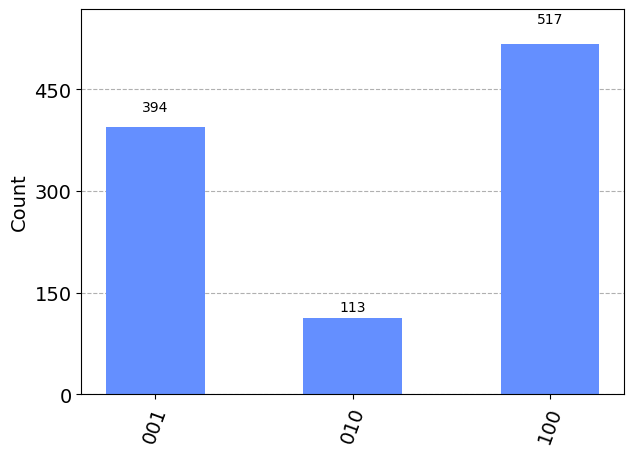

In [223]:
from qiskit.visualization import plot_histogram
print(v3)
plot_histogram(data=counts)

In [224]:
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere

In [225]:
# execute the quantum circuit
backend = Aer.get_backend(name='statevector_simulator') # the device to run on
result = backend.run(trans_qc, shots=1024).result()
psi = result.get_statevector(experiment=trans_qc)
psi

Statevector([0.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
             0.000000e+00+0.j, 3.061617e-16+1.j, 0.000000e+00+0.j,
             0.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
             0.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
             0.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
             0.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
             0.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
             0.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
             0.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
             0.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
             0.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
             0.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
             0.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
             0.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
             0.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+

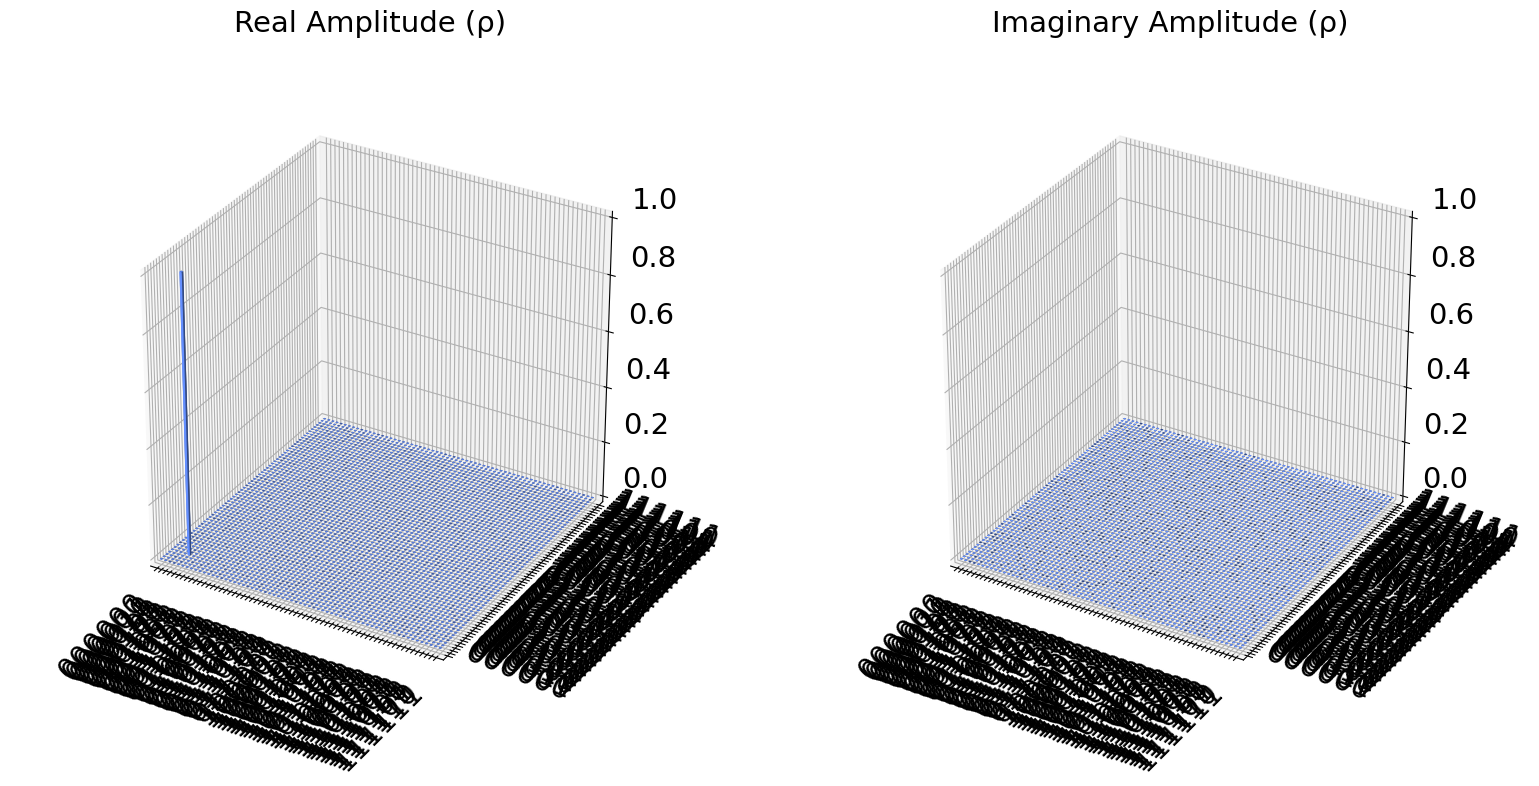

In [226]:
plot_state_city(state=psi)

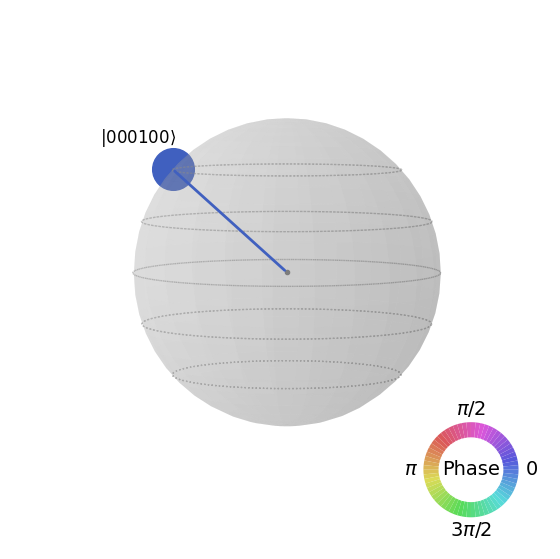

In [227]:
plot_state_qsphere(state=psi)

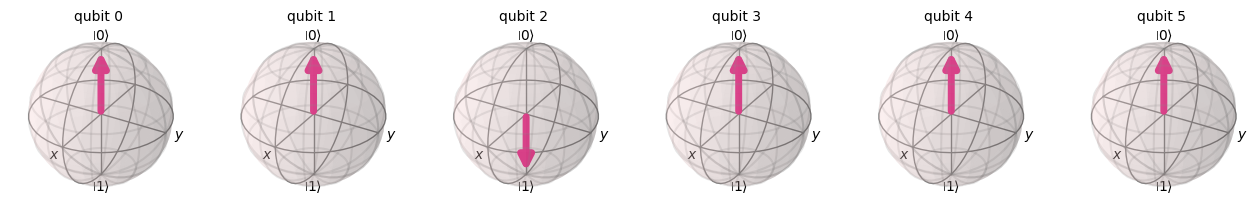

In [228]:
plot_bloch_multivector(state=psi)

In [229]:
import qiskit.utils
qiskit.utils.local_hardware_info()

{'python_compiler': 'GCC 11.4.0',
 'python_build': 'main, Nov 20 2023 15:14:05',
 'python_version': '3.10.12',
 'os': 'Linux',
 'cpus': 1}